**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**July, 2023**


---

##  1 - Preprocessing Lm

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline

import seaborn as sns
import seaborn as sb
import anndata
import matplotlib as mpl
import pickle 
import scrublet as scr

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

def Barplot(which_var, adata, var='leiden', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', dpi=100, orientation='landscape', format= 'pdf')
    
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/preprocessing/'
fig_path= '../results/images/preprocessing/'


sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


'/opt/conda/bin/python'

In [2]:
### Function to add the souporcell cluster
####

def add_souporcell_id(adata_obj, cell_id, samples):
    '''
    Function to add the souporcell status (e.g. 0,1, not pooled, etc.) to the cells
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
        samples: list of samples that were pooled. Usually not all samples are multiplexed.
    
    '''
    
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #print('sample',sample, 'barcode', cell_id)
    
    if curr_sample in samples:
        #extracts the table contained in the indicated key of the dictionary
        curr_souporcell_table = souporcell_clusters[curr_sample]
        
        if (cell_id in list(curr_souporcell_table.index)): #checking that the cells are into the data
            curr_assign = souporcell_clusters[curr_sample].loc[cell_id,'assignment']
            #print('returning',curr_assign)
            return(curr_assign)

        else:
            # cell barcode is filtered by souporcell
            return('filtered_by_souporcell')
    else:
        return('not_pooled')

In [3]:
def decode_donors(adata_obj, cell_id, identity_dict,samples):

    '''
    Function to add the true identity to the multiplexed samples. The souporcell samples are changed
    to the real names of the clusters(e.g. 0= Hrv99, 1=Hrv98).
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
        identity_dict: dictionary with the identity of each cluster per each sample. It has the structure sample:{cluster:donor}.
        samples: list of samples to be considered in the function. Not all samples are multiplexed
    '''
    
    
    #sample name
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #cluster name
    curr_souporcell_cluster = adata_obj.obs.loc[cell_id, 'assignment_SoC']

    if curr_sample in samples:
        #this means that the cell could not be assigned to a cluster (e.g. 2/3), therefore it is considered as a doublet
        if '/' in curr_souporcell_cluster:
            return('donor_doublets')
        
        #Condition for cells that were filtered by SoC. These will be deleted later.
        elif "filtered" in curr_souporcell_cluster:
            return('filtered_by_souporcell')
        
        #Singlets with a donor assigned
        else:
            return(identity_dict[curr_sample][curr_souporcell_cluster])


        

In [4]:
def donor_assing(adata_obj, cell_id):
    
    '''
    Function that assings a donor ID to the cells that were pooled and not pooled. It keep the ID stored in donor_deconv for those cells
    pooled, and the cells that weren't pooled will keep the original donor ID before deconvolution donor.
    
    input
        adata_obj: adata object
        cell_id:

    '''
    
    #Donor deconvoluted of the current cell
    curr_donor_deconv = adata_obj.obs.loc[cell_id, 'donor_deconv']
    #Donor of the current cell (before deconvolution)
    curr_donor = adata_obj.obs.loc[cell_id, 'donor']
    
    # donor ID from 'donor_id' column
    
    #If the curr_donor_deconv is None, then the function willl return the donor before deconvolution
    # Otherwise it will return the same donor in the donor_deconv column. Which is the real donor. 
    if curr_donor_deconv == 'None':
        return(curr_donor)
    
    elif curr_donor_deconv == None:
        return(curr_donor)
    
    else:
        return(curr_donor_deconv)

    

## Import meta data

In [6]:
data_dir = '/lustre/scratch126/cellgen/team292/er13/PlacInfection_revision/scRNAseq/data_integration/48h/data/Listeria/'
meta = pd.read_csv(data_dir+'meta_exp_infection_Lm_scell.csv',index_col=0)
meta['stage'] = meta['stage'].astype('str')
plotmeta = list(meta.columns)
plotmeta.append('sample')
print('Number of samples: ', meta.index.size)

Number of samples:  4


In [7]:
meta

,stage,donor,hpi,infection
sample,,,,
Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI
Pla_HDBR12330715,Lm_48h,Hrv136,48h,Lm
Pla_HDBR13661575,UI_48h,Hrv236,48h,UI
Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm


## Load GeneFull/filtered STARsolo outputs
### Preprocessing and merge matrix

Note: for parasites, skip basic filtering. Do filetering at later step.

In [52]:
data_dir = '/lustre/scratch126/cellgen/team292/er13/PlacInfection_revision/scRNAseq/data_integration/24h/data/Listeria/'


In [53]:
holder = []
for sample in meta.index:
    print(sample)
    holder.append(sc.read_10x_mtx(data_dir+sample+'/output/GeneFull/filtered/',var_names='gene_symbols',cache=True)) 
    # Set names of observation as sample + _ + barcode/probe
    holder[-1].var_names_make_unique()
    holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]
    #Filer cells with less than 100 genes expressed
    #sc.pp.filter_cells(holder[-1], min_genes=100)
    #Filer genes expressed in less than 3 cells
    #sc.pp.filter_genes(holder[-1], min_cells=3)
    # add in metadata
    holder[-1].obs['sample'] = sample 
    for val in meta.columns:
        holder[-1].obs[val] = meta[val][sample]
    # Extract mitochondial genes
    mito_genes = [name for name in holder[-1].var_names if name.startswith('MT')]
    #for each cell compute fraction of counts in mito genes vs. all genes
    #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
    holder[-1].obs['percent_mito'] = np.sum(
        holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1
    #add the total counts per cell as observations-annotation to adata
    holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1
    holder[-1].obs['n_genes'] = holder[-1].X.sum(axis=1).A1
    print('Total number of cells: {:d}'.format(holder[-1].n_obs))
    print('Total number of genes: {:d}'.format(holder[-1].n_vars))

Pla_HDBR12330714
Total number of cells: 14375
Total number of genes: 36601
Pla_HDBR12330715
Total number of cells: 13841
Total number of genes: 36601
Pla_HDBR13661575
Total number of cells: 15464
Total number of genes: 36601
Pla_HDBR13661576
Total number of cells: 17108
Total number of genes: 36601


In [54]:
# confirm N samples
print(len(holder))
# merge datasets by taking the intersection of cells found between nucleis and cells 
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)#batch_key='sample')
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

4


AnnData object with n_obs × n_vars = 60788 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'n_genes', 'batch'
    var: 'gene_ids', 'feature_types'

In [55]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0


In [56]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numi_vs_mito.pdf', show=False)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numi_vs_ngenes.pdf', show=False)

... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'donor' as categorical
... storing 'hpi' as categorical
... storing 'infection' as categorical
... storing 'feature_types' as categorical


In [57]:
adata.obs_names = adata.obs_names 

In [58]:
adata.obs['sample_barcode'] = adata.obs_names

In [59]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG


# Souporcell
Adding another column with deconvolution from souporcell

In [60]:
samples = list(np.unique(adata.obs['sample']))

In [61]:
#Only the multiplexed samples are included here
samples= ['Pla_HDBR12330714']

In [62]:
###reading in souporcell outputs
###

soc_path='/lustre/scratch126/cellgen/team292/er13/PlacInfection_revision/scRNAseq/data_integration/24h/data/Listeria/souporcell_donor/'

# sample to cluster
souporcell_clusters = {}


for sample in samples:
    print('sample', sample)
    path =soc_path+sample+'/clusters.tsv' #path to the souporcell output
    souporcell_clusters[sample] = pd.read_csv(path, sep='\t') #read souporcell output as pandas DF
    #aadind the DF into the dictionary
    souporcell_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in souporcell_clusters[sample]['barcode']]
    souporcell_clusters[sample]['sample_barcode'] = [elem.split('-')[0] for elem in souporcell_clusters[sample]['sample_barcode']]
    souporcell_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

sample Pla_HDBR12330714


In [63]:
#Adding a column into the metada that is actually the cell ID
adata.obs['sample_barcode'] = adata.obs.index

In [64]:
%%time
adata.obs['assignment_SoC'] = adata.obs['sample_barcode'].apply(lambda x: add_souporcell_id(adata,x,samples))

CPU times: user 14.7 s, sys: 3.78 ms, total: 14.7 s
Wall time: 14.8 s


In [65]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,assignment_SoC
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC,1
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT,0
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT,1
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT,1
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG,0/1
...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661576_TTTGTTGGTCACTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.026275,37298.0,37298.0,3,Pla_HDBR13661576_TTTGTTGGTCACTGAT,not_pooled
Pla_HDBR13661576_TTTGTTGGTTTCGGCG,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.044556,6576.0,6576.0,3,Pla_HDBR13661576_TTTGTTGGTTTCGGCG,not_pooled
Pla_HDBR13661576_TTTGTTGTCAGCTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.049094,21082.0,21082.0,3,Pla_HDBR13661576_TTTGTTGTCAGCTGAT,not_pooled
Pla_HDBR13661576_TTTGTTGTCGGTTGTA,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.082192,3942.0,3942.0,3,Pla_HDBR13661576_TTTGTTGTCGGTTGTA,not_pooled


#### Deconvolution of the donors
This step must be done even if there are not defined donors, in order to annotate the doublets.
The deconvolution of cluster equivalents was done using SoC shared_samples.py script. The loss values for true pairs must be low, in some cases, 1/10th that of invalid pairs.

In [66]:
### Building a dictionary with the identity of the cluster in each one of the samples.
### It has the structure SAMPLE:{Cluster:Donor,Cluster:Donor}

identity_dict={
    "Pla_HDBR12330714":{'0':'0','1':'1'}
    #"Pla_HDBR12330715":{'0':'1'} so the cluster 1 of Pla_HDBR12330714 corresponds to Hrv136 which is the only sample in Pla_HDBR12330715.
}

identity_dict

{'Pla_HDBR12330714': {'0': '0', '1': '1'}}

In [70]:
%%time
#NOTE: cells that weren't pooled will have None in the donor_deconv column
adata.obs['donor_deconv'] = adata.obs['sample_barcode'].apply(lambda x: decode_donors(adata,x,identity_dict, samples))

CPU times: user 1.31 s, sys: 2.27 ms, total: 1.31 s
Wall time: 1.31 s


In [71]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,assignment_SoC,donor_deconv
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC,1,1
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT,0,0
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT,1,1
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT,1,1
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG,0/1,donor_doublets


In [72]:
adata.obs.tail()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,assignment_SoC,donor_deconv
Pla_HDBR13661576_TTTGTTGGTCACTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.026275,37298.0,37298.0,3,Pla_HDBR13661576_TTTGTTGGTCACTGAT,not_pooled,None
Pla_HDBR13661576_TTTGTTGGTTTCGGCG,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.044556,6576.0,6576.0,3,Pla_HDBR13661576_TTTGTTGGTTTCGGCG,not_pooled,None
Pla_HDBR13661576_TTTGTTGTCAGCTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.049094,21082.0,21082.0,3,Pla_HDBR13661576_TTTGTTGTCAGCTGAT,not_pooled,None
Pla_HDBR13661576_TTTGTTGTCGGTTGTA,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.082192,3942.0,3942.0,3,Pla_HDBR13661576_TTTGTTGTCGGTTGTA,not_pooled,None
Pla_HDBR13661576_TTTGTTGTCTGGTTGA,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.135040,13322.0,13322.0,3,Pla_HDBR13661576_TTTGTTGTCTGGTTGA,not_pooled,None


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3]),
 [Text(0, 0, '1'), Text(1, 0, '0'), Text(2, 0, '1/0'), Text(3, 0, '0/1')])

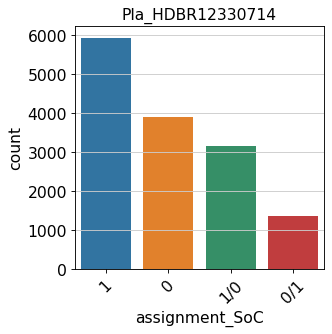

In [73]:
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['assignment_SoC'],
                order=adata[adata.obs['sample'] == sample].obs['assignment_SoC'].value_counts().index).set_title(sample)

plt.savefig(fig_path+'countplot_souporcell_id.pdf')
plt.xticks(rotation=45)

#### Applying the donor_assing function to the data. The donor names will be stored in the new column donor_souporcell

In [74]:
adata.obs['donor_souporcell'] = adata.obs['sample_barcode'].apply(lambda x: donor_assing(adata,x))

In [75]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,assignment_SoC,donor_deconv,donor_souporcell
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC,1,1,1
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT,0,0,0
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT,1,1,1
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT,1,1,1
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG,0/1,donor_doublets,donor_doublets
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661576_TTTGTTGGTCACTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.026275,37298.0,37298.0,3,Pla_HDBR13661576_TTTGTTGGTCACTGAT,not_pooled,None,Hrv236
Pla_HDBR13661576_TTTGTTGGTTTCGGCG,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.044556,6576.0,6576.0,3,Pla_HDBR13661576_TTTGTTGGTTTCGGCG,not_pooled,None,Hrv236
Pla_HDBR13661576_TTTGTTGTCAGCTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.049094,21082.0,21082.0,3,Pla_HDBR13661576_TTTGTTGTCAGCTGAT,not_pooled,None,Hrv236
Pla_HDBR13661576_TTTGTTGTCGGTTGTA,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.082192,3942.0,3942.0,3,Pla_HDBR13661576_TTTGTTGTCGGTTGTA,not_pooled,None,Hrv236


In [76]:
#Deleting the cells filtered by soc
adata= adata[adata.obs['assignment_SoC'] != 'filtered_by_souporcell']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [77]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,assignment_SoC,donor_deconv,donor_souporcell
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC,1,1,1
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT,0,0,0
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT,1,1,1
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT,1,1,1
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG,0/1,donor_doublets,donor_doublets


In [ ]:
identity_dict={
    "Pla_HDBR12330714":{'0':'0','1':'1'}
    #"Pla_HDBR12330715":{'0':'1'} so the cluster 1 of Pla_HDBR12330714 corresponds to Hrv136 which is the only sample in Pla_HDBR12330715.
}


#### Assigning donor id to cluster
Define cross matching samples

In [29]:
set(list(adata.obs.donor_souporcell))

{'0', '1', 'Hrv236', 'donor_doublets'}

In [78]:
#Function that changes the cluster names as indicated
adata.obs['donor_id'] = (adata.obs["donor_souporcell"].map(lambda x: 
                            {"0": "Hrv135", "1": "Hrv136",  "Hrv236":"Hrv236","Hrv136":"Hrv136","souporcell_doublet":"donor_doublets" }
                            .get(x, x)).astype("category"))

Trying to set attribute `.obs` of view, copying.


In [79]:
set(list(adata.obs.donor_id))

{'Hrv135', 'Hrv136', 'Hrv236', 'donor_doublets'}

In [80]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 60788


In [81]:
adata.obs= adata.obs.drop(columns=['donor_deconv','donor_souporcell'])

In [82]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,assignment_SoC,donor_id
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC,1,Hrv136
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT,0,Hrv135
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT,1,Hrv136
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT,1,Hrv136
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG,0/1,donor_doublets
...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661576_TTTGTTGGTCACTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.026275,37298.0,37298.0,3,Pla_HDBR13661576_TTTGTTGGTCACTGAT,not_pooled,Hrv236
Pla_HDBR13661576_TTTGTTGGTTTCGGCG,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.044556,6576.0,6576.0,3,Pla_HDBR13661576_TTTGTTGGTTTCGGCG,not_pooled,Hrv236
Pla_HDBR13661576_TTTGTTGTCAGCTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.049094,21082.0,21082.0,3,Pla_HDBR13661576_TTTGTTGTCAGCTGAT,not_pooled,Hrv236
Pla_HDBR13661576_TTTGTTGTCGGTTGTA,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.082192,3942.0,3942.0,3,Pla_HDBR13661576_TTTGTTGTCGGTTGTA,not_pooled,Hrv236


## Load scrublet

In [83]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    #reading the scrublet scores done in S0
    scrdf.append(pd.read_csv(data_dir+'scrublet-scores/'+sample+'.csv', header=0, index_col=0))
#scrdf.append(pd.read_csv('scrublet-scores/'+sample+'.csv', header=0, index_col=0))
#scrdf.append(pd.read_csv('scrublet-scores/'+sample+'soupX.csv', header=0, index_col=0))
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
for score in scorenames:
    adata.obs[score] = scrdf[score]
# In scrublet the significant p-value mark doublets
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

In [84]:
print('Total number of doublets: {:d}'.format(len(adata.obs.loc[adata.obs['is_doublet'] == True])))

Total number of doublets: 1415


In [85]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,assignment_SoC,donor_id,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC,1,Hrv136,0.047059,0.070301,-0.444098,0.857403,1.0,False
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT,0,Hrv135,0.068746,0.068746,-0.490344,0.857403,1.0,False
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT,1,Hrv136,NaN,NaN,NaN,NaN,NaN,False
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT,1,Hrv136,0.133690,0.101604,0.486429,0.857403,1.0,False
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG,0/1,donor_doublets,0.101604,0.070301,-0.444098,0.857403,1.0,False


In [86]:
adata.obs["infection"]

Pla_HDBR12330714_AAACCCAAGAGTCGAC    UI
Pla_HDBR12330714_AAACCCAAGATTCGCT    UI
Pla_HDBR12330714_AAACCCAAGTTTCGGT    UI
Pla_HDBR12330714_AAACCCACACAAGCTT    UI
Pla_HDBR12330714_AAACCCACACTACCGG    UI
                                     ..
Pla_HDBR13661576_TTTGTTGGTCACTGAT    Lm
Pla_HDBR13661576_TTTGTTGGTTTCGGCG    Lm
Pla_HDBR13661576_TTTGTTGTCAGCTGAT    Lm
Pla_HDBR13661576_TTTGTTGTCGGTTGTA    Lm
Pla_HDBR13661576_TTTGTTGTCTGGTTGA    Lm
Name: infection, Length: 60788, dtype: category
Categories (2, object): ['Lm', 'UI']

In [87]:
#concatenating columns and creating new one
adata.obs["infection_stage"] = adata.obs["infection"].astype('string') +'_'+ adata.obs["hpi"]

In [88]:
adata.obs["infection_stage"] = adata.obs["infection_stage"].astype("category")

In [89]:
set(adata.obs["infection_stage"])

{'Lm_48h', 'UI_48h'}

In [90]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,assignment_SoC,donor_id,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,infection_stage
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC,1,Hrv136,0.047059,0.070301,-0.444098,0.857403,1.000000,False,UI_48h
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT,0,Hrv135,0.068746,0.068746,-0.490344,0.857403,1.000000,False,UI_48h
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT,1,Hrv136,NaN,NaN,NaN,NaN,NaN,False,UI_48h
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT,1,Hrv136,0.133690,0.101604,0.486429,0.857403,1.000000,False,UI_48h
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG,0/1,donor_doublets,0.101604,0.070301,-0.444098,0.857403,1.000000,False,UI_48h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661576_TTTGTTGGTCACTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.026275,37298.0,37298.0,3,Pla_HDBR13661576_TTTGTTGGTCACTGAT,not_pooled,Hrv236,0.190000,0.219580,4.068406,0.000500,0.366214,False,Lm_48h
Pla_HDBR13661576_TTTGTTGGTTTCGGCG,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.044556,6576.0,6576.0,3,Pla_HDBR13661576_TTTGTTGGTTTCGGCG,not_pooled,Hrv236,0.064356,0.065011,-0.017308,0.803041,1.000000,False,Lm_48h
Pla_HDBR13661576_TTTGTTGTCAGCTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.049094,21082.0,21082.0,3,Pla_HDBR13661576_TTTGTTGTCAGCTGAT,not_pooled,Hrv236,0.059382,0.057043,-0.227930,0.803041,1.000000,False,Lm_48h
Pla_HDBR13661576_TTTGTTGTCGGTTGTA,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.082192,3942.0,3942.0,3,Pla_HDBR13661576_TTTGTTGTCGGTTGTA,not_pooled,Hrv236,0.061818,0.077239,0.305895,0.803041,1.000000,False,Lm_48h


In [91]:
# adding the raw counts
adata.layers['raw_counts']=adata.X

In [92]:
import gc

In [93]:
del(holder)

In [94]:
gc.collect()

10335

## Calculate cell-cycle scores AND (optional)regress out cell cycle genes

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at RegevLab Github repo.

In [95]:
#Normalizing the data and scaling for the cell-cycle scoring
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


# Scale
sc.pp.scale(adata, max_value=10)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [96]:
gc.collect()

228

In [97]:
# Regress out cell cycle genes
cell_cycle_genes = [x.strip() for x in open('../../24h/data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# sc.pp.regress_out(adata, ['S_score', 'G2M_score']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [98]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,n_genes,batch,sample_barcode,...,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,infection_stage,S_score,G2M_score,phase
Pla_HDBR12330714_AAACCCAAGAGTCGAC,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.071508,9887.0,9887.0,0,Pla_HDBR12330714_AAACCCAAGAGTCGAC,...,0.047059,0.070301,-0.444098,0.857403,1.000000,False,UI_48h,-0.177949,-0.270690,G1
Pla_HDBR12330714_AAACCCAAGATTCGCT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.025856,1431.0,1431.0,0,Pla_HDBR12330714_AAACCCAAGATTCGCT,...,0.068746,0.068746,-0.490344,0.857403,1.000000,False,UI_48h,0.061132,0.038379,S
Pla_HDBR12330714_AAACCCAAGTTTCGGT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.519080,1913.0,1913.0,0,Pla_HDBR12330714_AAACCCAAGTTTCGGT,...,NaN,NaN,NaN,NaN,NaN,False,UI_48h,0.319312,0.034964,S
Pla_HDBR12330714_AAACCCACACAAGCTT,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.022717,2201.0,2201.0,0,Pla_HDBR12330714_AAACCCACACAAGCTT,...,0.133690,0.101604,0.486429,0.857403,1.000000,False,UI_48h,0.041881,0.191538,G2M
Pla_HDBR12330714_AAACCCACACTACCGG,Pla_HDBR12330714,UI_48h,Hrv135_Hrv136,48h,UI,0.047929,1231.0,1231.0,0,Pla_HDBR12330714_AAACCCACACTACCGG,...,0.101604,0.070301,-0.444098,0.857403,1.000000,False,UI_48h,0.036277,-0.157558,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661576_TTTGTTGGTCACTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.026275,37298.0,37298.0,3,Pla_HDBR13661576_TTTGTTGGTCACTGAT,...,0.190000,0.219580,4.068406,0.000500,0.366214,False,Lm_48h,0.039570,-0.076960,S
Pla_HDBR13661576_TTTGTTGGTTTCGGCG,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.044556,6576.0,6576.0,3,Pla_HDBR13661576_TTTGTTGGTTTCGGCG,...,0.064356,0.065011,-0.017308,0.803041,1.000000,False,Lm_48h,0.417412,1.025595,G2M
Pla_HDBR13661576_TTTGTTGTCAGCTGAT,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.049094,21082.0,21082.0,3,Pla_HDBR13661576_TTTGTTGTCAGCTGAT,...,0.059382,0.057043,-0.227930,0.803041,1.000000,False,Lm_48h,0.118711,-0.028451,S
Pla_HDBR13661576_TTTGTTGTCGGTTGTA,Pla_HDBR13661576,Lm_48h,Hrv236,48h,Lm,0.082192,3942.0,3942.0,3,Pla_HDBR13661576_TTTGTTGTCGGTTGTA,...,0.061818,0.077239,0.305895,0.803041,1.000000,False,Lm_48h,-0.143870,0.129952,G2M


### Save raw counts

In [99]:
# adding the raw counts
adata.X= adata.layers['raw_counts']
#adata.raw = adata.copy
adata.write('../data/rna1_counts_Lm_adata.h5ad')

... storing 'assignment_SoC' as categorical
... storing 'phase' as categorical


In [100]:
adata

AnnData object with n_obs × n_vars = 60788 × 36601
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'n_genes', 'batch', 'sample_barcode', 'assignment_SoC', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage', 'S_score', 'G2M_score', 'phase'
    var: 'gene_ids', 'feature_types', 'mean', 'std'
    uns: 'log1p'
    layers: 'raw_counts'